# DETECCION DE PEATONES CON HOG Y SVM


# Se cargan las bibliotecas necesarias

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog

# Se importan los dos datasets 
### https://docs.python.org/3/library/glob.html

In [15]:
import glob

#vehicle = glob.glob("data_svm/vehicles/**/*.png")
#no_vehicle = glob.glob("data_svm/non-vehicles/**/*.png")

peaton = glob.glob(r"peatones/si_peatones/**/*.*")

#no_peaton = glob.glob("peatones/no_peatones/*.jpg")
no_peaton = glob.glob(r"D:\Navegación Autónoma_Scripts\03_Machine_Learning\data_svm\non-vehicles\**\*.png")

In [16]:
#len(vehicle)
len(peaton)

2241

In [17]:
#len(no_vehicle)
len(no_peaton)

3900

# Se muestra una imagen con vehículo

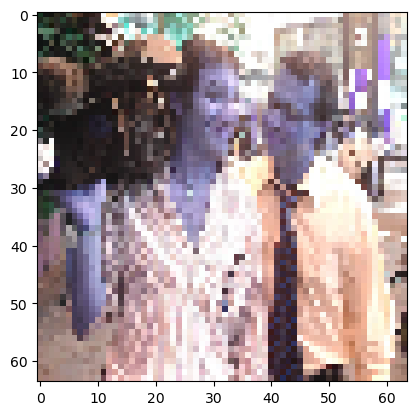

In [18]:
img = cv2.imread(peaton[17])
img_color_peaton = cv2.resize(img, (64,64)) #Estandarizamos el tamaño de todas las imágenes para poder procesarlas.
plt.imshow(img_color_peaton)

In [19]:
img_non = cv2.imread(no_peaton[1])
#img_non2 = cv2.resize(img_non, (64, 64))
#plt.imshow(img_non)

# Para fines de demostración se calcula el HOG de la imagen

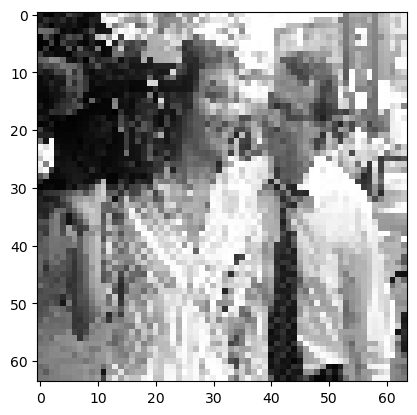

In [20]:
img_gray_peaton = cv2.cvtColor(img_color_peaton,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray_peaton,cmap="gray")

In [21]:
features,hog_img = hog(img_gray_peaton,
                       orientations = 10,
                       pixels_per_cell = (16,16),
                       cells_per_block = (2,2),
                       transform_sqrt = False,
                       visualize = True,
                       feature_vector = True)

In [22]:
features.shape

(360,)

In [23]:
hog_img.shape

(64, 64)

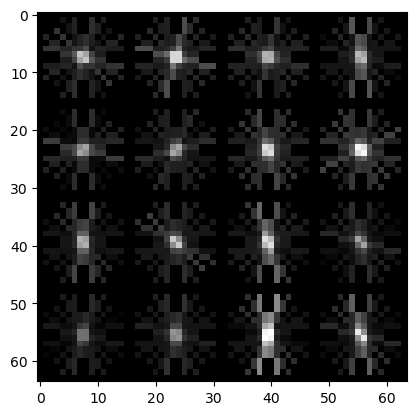

In [24]:
plt.imshow(hog_img,cmap = 'gray')

# Se extraen las features del HOG para ambos tipos de datos

In [25]:
peaton_hog_accum = []

for i in peaton:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    img_res = cv2.resize(img_gray, (64,64))
    peaton_hog_feature, peaton_hog_img = hog(img_res,
                                               orientations = 10,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    peaton_hog_accum.append(peaton_hog_feature)

In [26]:
X_peaton = np.vstack(peaton_hog_accum).astype(np.float64)
y_peaton = np.ones(len(X_peaton))

In [27]:
X_peaton.shape

(2241, 360)

In [28]:
y_peaton.shape

(2241,)

In [29]:
no_peaton_hog_accum = []

for i in no_peaton:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    no_peaton_hog_feature, no_peaton_hog_img = hog(img_gray,
                                               orientations = 10,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    no_peaton_hog_accum.append(no_peaton_hog_feature)

In [30]:
X_no_peaton = np.vstack(no_peaton_hog_accum).astype(np.float64)
y_no_peaton = np.zeros(len(X_no_peaton))

In [31]:
X_no_peaton.shape

(3900, 360)

In [32]:
y_no_peaton.shape

(3900,)

# Se combinan ambos tipos de datos para alimentar el SVM

In [33]:
X = np.vstack((X_peaton,X_no_peaton))
X.shape

(6141, 360)

In [34]:
y = np.hstack((y_peaton,y_no_peaton))
y.shape

(6141,)

# Se generan los datos de entrenamiento y de prueba

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [36]:
X_train.shape

(4298, 360)

In [37]:
X_test.shape

(1843, 360)

# Se importa el Clasificador y se entrena

In [38]:
#from sklearn.svm import LinearSVC

#svc_model = LinearSVC()
#svc_model.fit(X_train, y_train)
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)

SVC()

In [39]:
y_predict = svc_model.predict(X_test)

<Axes: >

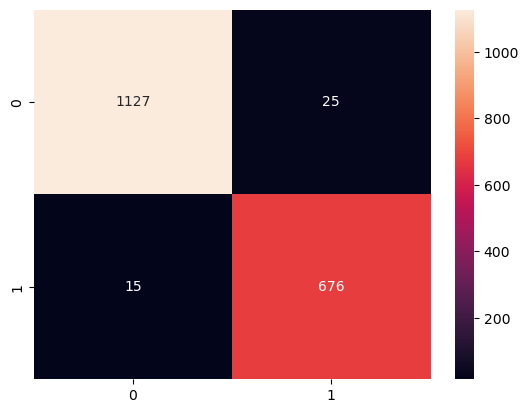

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot=True, fmt = "d")

In [41]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1152
         1.0       0.96      0.98      0.97       691

    accuracy                           0.98      1843
   macro avg       0.98      0.98      0.98      1843
weighted avg       0.98      0.98      0.98      1843



# GridSearchCV

In [42]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [43]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.938 total time=   2.9s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.936 total time=   2.9s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.947 total time=   2.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.953 total time=   2.8s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.936 total time=   2.6s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.962 total time=   1.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.960 total time=   1.4s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.959 total time=   1.5s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.969 total time=   1.6s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.959 total time=   1.8s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.942 total time=   3.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

In [44]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [45]:
grid.best_estimator_

SVC(C=10, gamma=0.1)

In [46]:
grid_predictions = grid.predict(X_test)

<Axes: >

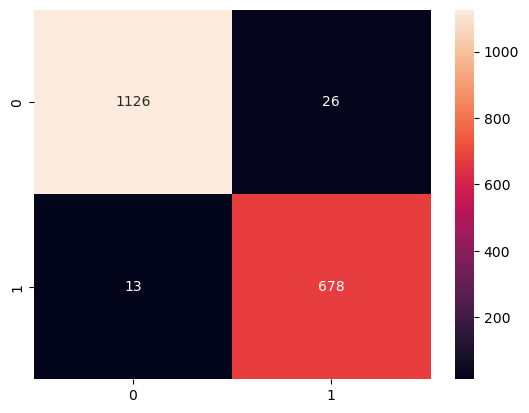

In [47]:
cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt = "d")

In [48]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1152
         1.0       0.96      0.98      0.97       691

    accuracy                           0.98      1843
   macro avg       0.98      0.98      0.98      1843
weighted avg       0.98      0.98      0.98      1843

